In [559]:
import pymc3 as pm
import arviz as az

import cdms2 as cdms
import genutil,cdutil
import MV2 as MV
import glob
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("/Users/kmarvel/Documents/GIT/python-utils/")
import matplotlib.cm as cm

import pandas as pd

import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import calendar

import pickle

from pymc3.distributions import Interpolated

from scipy import stats
import seaborn as sns

def get_forcing_colors(forcing):
    c=cm.tab10
    d={}
    d["ghg"]=c(2)
    d["volc"]=c(3)
    d["aer"]=c(1)
    d["lu"]=c(5)
    d["oz"]=c(4)
    d["orb"]=c(6)
    d["sol"]=c(8)
    d["obs"]=c(0)
    return d[(forcing.lower())]

direc="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/"


variables=["SAT","MSU_TLT","MSU_TMT","MSU_TLS","SSU_ch1","SSU_ch2","SSU_ch3"]
#variable="SSU_ch3"

def forced_response(forcing):
    stem=direc+"for_kate/E213"
    direcs=glob.glob(stem+forcing+"*")
    L_ens=len(direcs)
    i_ens=0
    if forcing != "piControl":
        nt=165
    else:
        nt=959
    ensemble=np.zeros((L_ens,len(variables),nt))
    for drc in direcs:
        subdir=drc+"/lpl_data/"
        i_var=0
        for variable in variables:
            datafile=glob.glob(subdir+variable+"*")[0]
            #print(datafile)
            df=pd.read_csv(datafile, delim_whitespace=True,skiprows=4,names=["Year","Value"])
            if forcing != "piControl":
                if df.Year.values[0]==1850:
                    toput=df[(df.Year<2014+1) & (df.Year>=1850)].values[:,1]
                else:
                    toput=df[(df.index<2014+1) & (df.index>=1850)].values[:,1]
            else:
                toput=df.values[:,1]
            ensemble[i_ens,i_var]=toput
            i_var+=1
        i_ens+=1
    return ensemble

years=np.arange(1850,2015,1)


def forced_anomalies(forcing,average=True,startyear=1979,stopyear=2014,climstart=1979,climstop=2014):
    years=np.arange(1850,2015,1)
    start=int(np.where(years==startyear)[0])
    stop=int(np.where(years==stopyear)[0])+1
    ensemble=forced_response(forcing)
    

    climatology=np.average(ensemble[:,:,int(np.where(years==climstart)[0]):int(np.where(years==climstop)[0])+1],axis=-1)
    anomalies=ensemble-climatology[:,:,np.newaxis]
    anomalies=anomalies[:,:,start:stop]

    if average:
        ens_av=np.average(anomalies,axis=0)
        return ens_av
    else:
        return anomalies

def forced_dictionary(forcing,startyear=1979,stopyear=2014,climstart=1979,climstop=2014):
    d={}
    variables=["SAT","MSU_TLT","MSU_TMT","MSU_TLS","SSU_ch1","SSU_ch2","SSU_ch3"]
    anomalies=forced_anomalies(forcing,average=False,startyear=startyear,stopyear=stopyear,climstart=climstart,climstop=climstop)
    for i in range(len(variables)):
        d[variables[i]]=anomalies[:,i]
    return d

def get_obs(startyear=1979,stopyear=2014,climstart=1979,climstop=2014):
    OBS={}
    obsdir="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/"
    OBS["SAT"]={}
    gistemp="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/GISTEMP/gistemp_v4_ann.lp"
    gistemp_df=pd.read_csv(gistemp, sep=' ',skiprows=4,names=["Year","Value"])
    gistemp_years=gistemp_df.Year
    hadcrut="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/HadCRUT/hadcrut5_ann.lp"
    hadcrut_df=pd.read_csv(hadcrut, sep=' ',skiprows=4,names=["Year","Value"])
    hadcrut_years=hadcrut_df.Year


    gistemp_clim=np.average(gistemp_df[(gistemp_years<climstop+1) & (gistemp_years>=climstart)].Value)
    hadcrut_clim=np.average(hadcrut_df[(hadcrut_years<climstop++1) & (hadcrut_years>=climstart)].Value)

    gistemp_anom=gistemp_df[(gistemp_years<stopyear+1) & (gistemp_years>=startyear)].values[:,1]-gistemp_clim


    hadcrut_anom=hadcrut_df[(hadcrut_years<stopyear+1) & (hadcrut_years>=startyear)].values[:,1]-hadcrut_clim
    OBS["SAT"]["GISTEMP"]=gistemp_anom
    OBS["SAT"]["HadCRUT"]=hadcrut_anom

    OBS["MSU_TLT"]={}
    rss="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/RSS/rss4_tlt_ann.lp"
    rss_df=pd.read_csv(rss, sep=' ',skiprows=4,names=["Year","Value"])
    rss_clim=np.average(rss_df[(rss_df.Year<climstop+1) & (rss_df.Year>=climstart)].Value)
    rss_anom=rss_df[(rss_df.Year<stopyear+1) & (rss_df.Year>=startyear)].values[:,1]-rss_clim
    OBS["MSU_TLT"]["RSS"]=rss_anom

    uah="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/UAH/uah6_tlt_ann.lp"
    uah_df=pd.read_csv(uah, sep=' ',skiprows=4,names=["Year","Value"])
    uah_clim=np.average(uah_df[(uah_df.Year<climstop+1) & (uah_df.Year>=climstart)].Value)
    uah_anom=uah_df[(uah_df.Year<stopyear+1) & (uah_df.Year>=startyear)].values[:,1]-uah_clim
    OBS["MSU_TLT"]["UAH"]=uah_anom

    #Mid-troposphere
    OBS["MSU_TMT"]={}
    rss="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/RSS/rss4_tmt_ann.lp"
    rss_df=pd.read_csv(rss, sep=' ',skiprows=4,names=["Year","Value"])
    rss_clim=np.average(rss_df[(rss_df.Year<climstop+1) & (rss_df.Year>=climstart)].Value)
    rss_anom=rss_df[(rss_df.Year<stopyear+1) & (rss_df.Year>=startyear)].values[:,1]-rss_clim
    OBS["MSU_TMT"]["RSS"]=rss_anom

    uah="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/UAH/uah6_tmt_ann.lp"
    uah_df=pd.read_csv(uah, sep=' ',skiprows=4,names=["Year","Value"])
    uah_clim=np.average(uah_df[(uah_df.Year<climstop+1) & (uah_df.Year>=climstart)].Value)
    uah_anom=uah_df[(uah_df.Year<stopyear+1) & (uah_df.Year>=startyear)].values[:,1]-uah_clim
    OBS["MSU_TMT"]["UAH"]=uah_anom
    #NOAA STAR
    noaa="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/NOAA_star/noaa_star4.1_tmt_ann.lp"
    noaa_df=pd.read_csv(noaa, sep=' ',skiprows=4,names=["Year","Value"])
    noaa_clim=np.average(noaa_df[(noaa_df.Year<climstop+1) & (noaa_df.Year>=climstart)].Value)
    noaa_anom=noaa_df[(noaa_df.Year<stopyear+1) & (noaa_df.Year>=startyear)].values[:,1]-noaa_clim
    OBS["MSU_TMT"]["NOAA_star"]=noaa_anom

    #Lower stratosphere
    OBS["MSU_TLS"]={}
    #RSS
    rss="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/RSS/rss4_tls_ann.lp"
    rss_df=pd.read_csv(rss, sep=' ',skiprows=4,names=["Year","Value"])
    rss_clim=np.average(rss_df[(rss_df.Year<climstop+1) & (rss_df.Year>=climstart)].Value)
    rss_anom=rss_anom=rss_df[(rss_df.Year<stopyear+1) & (rss_df.Year>=startyear)].values[:,1]-rss_clim
    OBS["MSU_TLS"]["RSS"]=rss_anom
    #UAH
    uah="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/UAH/uah6_tls_ann.lp"
    uah_df=pd.read_csv(uah, sep=' ',skiprows=4,names=["Year","Value"])
    uah_clim=np.average(uah_df[(uah_df.Year<climstop+1) & (uah_df.Year>=climstart)].Value)
    uah_anom=uah_df[(uah_df.Year<stopyear+1) & (uah_df.Year>=startyear)].values[:,1]-uah_clim
    OBS["MSU_TLS"]["UAH"]=uah_anom
    #NOAA STAR
    noaa="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/NOAA_star/noaa_star4.1_tls_ann.lp"
    noaa_df=pd.read_csv(noaa, sep=' ',skiprows=4,names=["Year","Value"])
    noaa_clim=np.average(noaa_df[(noaa_df.Year<climstop+1) & (noaa_df.Year>=climstart)].Value)
    noaa_anom=noaa_df[(noaa_df.Year<stopyear+1) & (noaa_df.Year>=startyear)].values[:,1]-noaa_clim
    OBS["MSU_TLS"]["NOAA_star"]=noaa_anom

    #SSU
    noaa="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/NOAA_star/ssu_anom_ann.lp"
    noaa_df=pd.read_csv(noaa, sep=' ',header=None,names=["Year","SSU_ch1","SSU_ch2","SSU_ch3"])
    noaa_trunc=noaa_df[(noaa_df.Year<stopyear+1) & (noaa_df.Year>=startyear)]
    noaa_trunc_clim=noaa_df[(noaa_df.Year<climstop+1) & (noaa_df.Year>=climstart)]
    OBS["SSU_ch1"]={}
    OBS["SSU_ch1"]["NOAA_star"]=noaa_trunc.SSU_ch1.values-np.average(noaa_trunc_clim.SSU_ch1.values)
    OBS["SSU_ch2"]={}
    OBS["SSU_ch2"]["NOAA_star"]=noaa_trunc.SSU_ch2.values-np.average(noaa_trunc_clim.SSU_ch2.values)
    OBS["SSU_ch3"]={}
    OBS["SSU_ch3"]["NOAA_star"]=noaa_trunc.SSU_ch3.values-np.average(noaa_trunc_clim.SSU_ch3.values)
    return OBS

def single_variable_obs(variable):  
    datasets=list(OBS[variable].keys())
    ndatasets=len(datasets)
    nt=OBS[variable][datasets[0]].shape[0]
    ARR=np.zeros((ndatasets,nt))
    for i in range(ndatasets):
        ARR[i]=OBS[variable][datasets[i]]
    return ARR

# Data read-in
The following code reads in E2.1 3 ensembles and multiple observational datasets.  

In [499]:
#Satellite data all starts in 1979.  Cut off in 2014 for consistency with historical model experiments
startyear=1979
stopyear=2014
#Calculate anomalies relative to 1979-1999
climstart=1979
climstop=1999

In [500]:
allforcings={"GHG":"GHG",\
             "LUir":"LU",\
             "O3": "Oz",\
             "ORB": "Orb",\
             "S0": "Sol",\
             "TA": "Aer",\
             "VA": "Volc"}
             
ENS={}
for forcing in allforcings.keys():
    
    ENS[allforcings[forcing]]=forced_anomalies(forcing,\
                                               average=False,startyear=startyear,stopyear=stopyear,\
                                               climstart=climstart,climstop=climstop)

OBS=get_obs(startyear=startyear,stopyear=stopyear,\
            climstart=climstart,climstop=climstop)


In [509]:
theobs=single_variable_obs(variable)
theobs.shape

(2, 36)

In [510]:
#Returns the regression model over multiple forcings
def bayesian_model(variable):
    ivar=list(OBS.keys()).index(variable)
    theobs=single_variable_obs(variable)
    ndatasets,nt=theobs.shape
    with pm.Model() as AllForcingsModel:
        model_internal_variability=pm.HalfNormal("σ2_GCM",10)
        obs_internal_variability=pm.HalfNormal("σ2",10)
       #Priors on latent forced responses and their scaling factors
        betas={}
        latent={}
        likelihoods={}
        forced_response=0.
        for forcing in ENS.keys():
            betas[forcing]=pm.Normal("β_"+forcing,0,1)
            latent[forcing]=pm.Normal("latent_"+forcing,0,10,shape=nt)
            likelihoods[forcing]=pm.Normal("likelihood_"+forcing,\
                                           mu=latent[forcing],\
                                           sd=model_internal_variability,\
                                          observed=ENS[forcing][:,ivar])
            forced_response+=betas[forcing]*latent[forcing]

        if theobs.shape[0] >1:
            obs_est=pm.Normal("obs_est",mu=forced_response,sd=obs_internal_variability,shape=nt)
            obs_uncertainty=pm.HalfNormal("obs_uncertainty",10)
            likelihood_obs=pm.Normal("likelihood_obs",mu=obs_est,sd=obs_uncertainty,\
                                             observed=theobs)
        else:
            #likelihood_obs=pm.Normal("likelihood_obs",mu=forced_response,sd=observed_internal_variability,observed=self.obs)
            likelihood_obs=pm.Normal("likelihood_obs",\
                   mu=forced_response,\
                   sd=obs_internal_variability,\
                   observed=theobs[0])
    return AllForcingsModel

In [511]:
sample_traces=True
if sample_traces:
    traces={}
    for variable in OBS.keys():
        with bayesian_model(variable):
            traces[variable]=pm.sample(return_inferencedata=True)

    with open("SingleForcingTime_Inference.pkl","wb") as picklefile:
        pickle.dump(traces,picklefile)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_uncertainty, obs_est, latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7047765831709949, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_uncertainty, obs_est, latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7178863581688827, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_uncertainty, obs_est, latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_uncertainty, obs_est, latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [latent_Volc, β_Volc, latent_Aer, β_Aer, latent_Sol, β_Sol, latent_Orb, β_Orb, latent_Oz, β_Oz, latent_LU, β_LU, latent_GHG, β_GHG, σ2, σ2_GCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [504]:
read_traces_from_file=False
if read_traces_from_file:
    with open("SingleForcingTimeTraces.pkl","rb") as picklefile:
        traces=pickle.load(picklefile)

# Scaling Factors
Bayesian posteriors for the scaling factors $\beta_i$ associated with the GCM-simulated response to each forcing $i$.

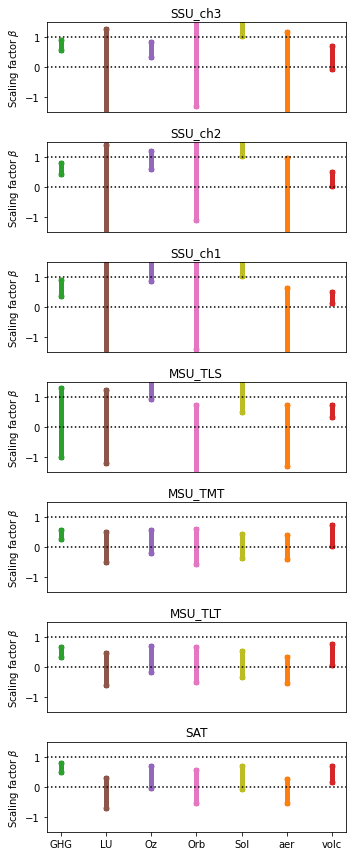

In [401]:
plt.figure(figsize=(5,12))
counter=1
for variable in list(OBS.keys())[::-1]:
    plt.subplot(7,1,counter)
    i=0
    for forcing in ENS.keys():
        plt.plot(np.zeros(2)+i,az.hdi(getattr(traces[variable],"β_"+forcing)),\
                 lw=5,ls="-",marker="o",markersize=5,\
                 color=get_forcing_colors(forcing))
        i+=1
    plt.axhline(0,ls=":",c="k")
    plt.axhline(1,ls=":",c="k")
    tmp=plt.xticks([])
    counter+=1
    plt.ylim(-1.5,1.5)
    plt.title(variable)
    plt.ylabel(r"Scaling factor $\beta$")
tmp=plt.xticks(np.arange(len(ENS.keys())),list(ENS.keys()))
plt.tight_layout()

In [546]:
arr=idata.posterior.β_GHG*idata.posterior.latent_GHG
arr.mean(dim=["chain","draw"])

<xarray.DataArray (latent_GHG_dim_0: 36)>
array([-0.190913  , -0.08310447, -0.0853875 , -0.07489593, -0.04221191,
        0.01708561, -0.04924977, -0.12343567, -0.03272404,  0.062475  ,
        0.00139754, -0.0236368 , -0.03461585,  0.00381746,  0.08790551,
        0.0484965 ,  0.03563703,  0.08554815,  0.12873749,  0.19442847,
        0.0670843 ,  0.07778793,  0.16774809,  0.16787913,  0.19308574,
        0.15893867,  0.19496379,  0.2405896 ,  0.17937816,  0.14574104,
        0.256508  ,  0.30400392,  0.185362  ,  0.21503537,  0.3440782 ,
        0.34210033])
Coordinates:
  * latent_GHG_dim_0  (latent_GHG_dim_0) int64 0 1 2 3 4 5 ... 30 31 32 33 34 35

In [574]:
def response_and_scaled_response(variable,forcing):
    idata=traces[variable]
    x=np.arange(36)+1979
    if "obs_est" in idata.posterior.keys():

        az.plot_hdi(x,idata.posterior["obs_est"],color="k",smooth=False)
    else:
        plt.plot(x,OBS[variable]["NOAA_star"],color="k")
        
    beta=getattr(idata.posterior,"β_"+forcing)
    response=getattr(idata.posterior,"latent_"+forcing)
    scaled=beta*response
    az.plot_hdi(x,\
                response\
                ,color=get_forcing_colors(forcing),smooth=False,hdi_prob=.90)
    plt.plot(x,scaled.mean(dim=["chain","draw"]),color=get_forcing_colors(forcing),ls="--",label="scaled response")
    plt.legend()

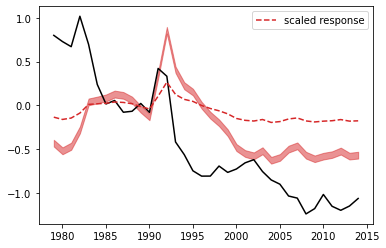

In [575]:
#The volcanic response in the stratosphere is too large and too long-lasting
response_and_scaled_response("SSU_ch1","Volc")

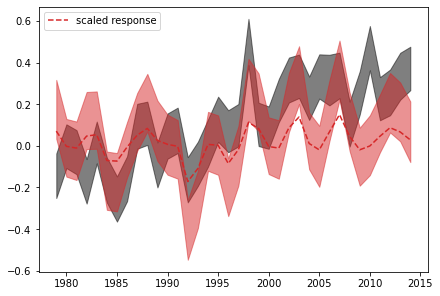

In [579]:
#It's also too large (but temporally ok) in the troposphere
response_and_scaled_response("MSU_TLT","Volc")

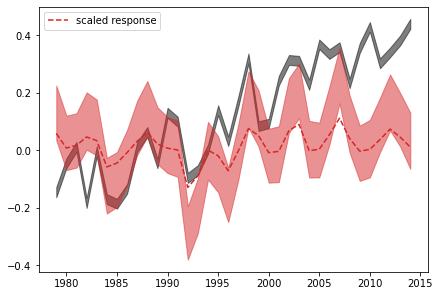

In [580]:
response_and_scaled_response("SAT","Volc")

In [561]:
def plot_scaled_contributions(variable):
    idata=traces[variable]
    x=np.arange(36)+1979
    if "obs_est" in idata.posterior.keys():

        az.plot_hdi(x,idata.posterior["obs_est"],color="k",smooth=False)
    else:
        plt.plot(x,OBS[variable]["NOAA_star"],color="k")
    for forcing in ENS.keys():
        beta=getattr(idata.posterior,"β_"+forcing)
        response=getattr(idata.posterior,"latent_"+forcing)
        scaled=beta*response
        az.plot_hdi(x,\
                    scaled\
                    ,color=get_forcing_colors(forcing),smooth=False,hdi_prob=.66)



    #az.plot_hdi(x,trace.latent_GHG,color="g")
    #az.plot_hdi(x,trace.latent_aer,color="orange")
    #az.plot_hdi(x,trace.latent_LU,color="brown")
    #plt.plot(x,OBS["SSU_ch3"]["NOAA_star"],color="k")
    plt.axhline(0,c="k",ls=":")

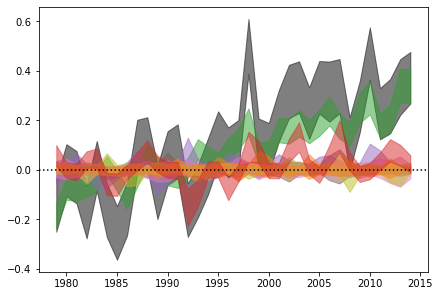

In [562]:
plot_scaled_contributions("MSU_TLT")

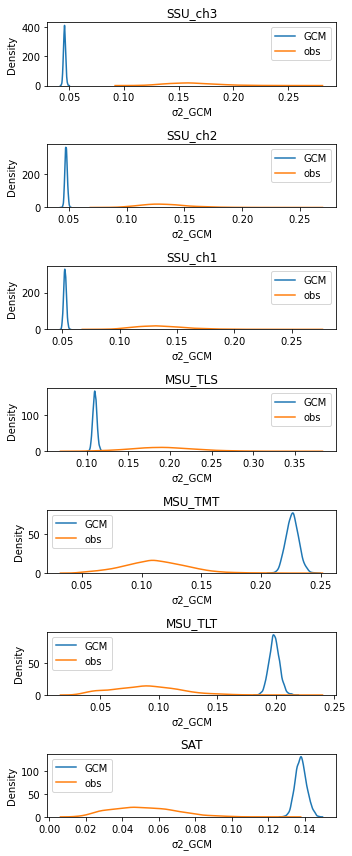

In [587]:
plt.figure(figsize=(5,12))
counter=1
for variable in list(OBS.keys())[::-1]:
    plt.subplot(7,1,counter)
    sns.kdeplot(traces[variable].posterior.σ2_GCM.stack(draws=("chain", "draw")),label="GCM")
    sns.kdeplot(traces[variable].posterior.σ2.stack(draws=("chain", "draw")),label="obs")
    plt.title(variable)
    
    counter+=1
    plt.legend()
plt.tight_layout()


/Users/kmarvel/Applications/anaconda3/envs/cdat_lite/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


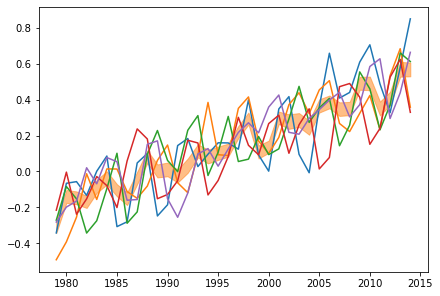

In [462]:
test=trace.latent_GHG
test.shape


az.plot_hdi(x,test,smooth=False,hdi_prob=.5)


tmp=[plt.plot(x,ENS["GHG"][i,0,:]) for i in range(5)]

0.5384822561325854
[0.54581004 0.79806346]


/Users/kmarvel/Applications/anaconda3/envs/cdat_lite/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


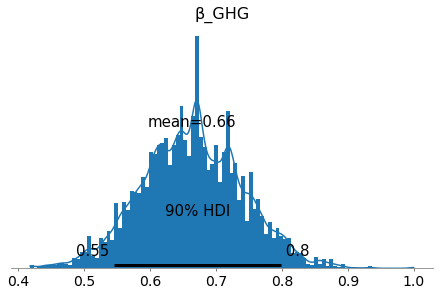

In [435]:
print(np.percentile(trace.β_GHG,5))
print(az.hdi(trace.β_GHG,hdi_prob=.9))
az.plot_posterior(trace,var_names=["β_GHG"],hdi_prob=.9)
tmp=plt.hist(trace.β_GHG,100,density=True)

/Users/kmarvel/Applications/anaconda3/envs/cdat_lite/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


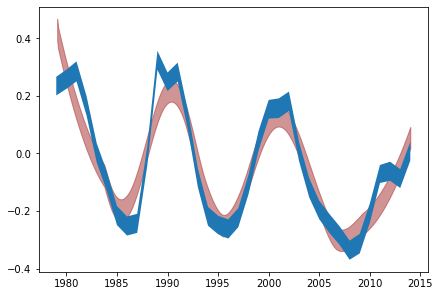

In [423]:
#[plt.plot(x,ENS["Sol"][i,-1]) for i in range(5)]
p5=np.percentile(trace_SSU.latent_Sol,5,axis=0)
p95=np.percentile(trace_SSU.latent_Sol,95,axis=0)
#plt.plot(x,np.average(ENS["Sol"],axis=0)[-1])
az.plot_hdi(x,trace_SSU.latent_Sol,color="brown")
plt.fill_between(x,p5,p95)

/Users/kmarvel/Applications/anaconda3/envs/cdat_lite/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


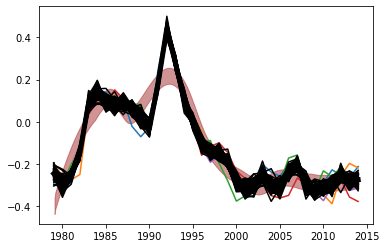

In [414]:
[plt.plot(x,ENS["volc"][i,-1]) for i in range(5)]
az.plot_hdi(x,trace_SSU.latent_volc,color="brown")
[plt.plot(x,trace_SSU.latent_volc[i],c="k") for i in range(100)]
plt.plot(x,np.average(trace_SSU.latent_volc,axis=0),lw=5,c="k")

In [324]:
az.hdi(trace.β_GHG)

array([0.52301347, 0.80973785])

/Users/kmarvel/Applications/anaconda3/envs/cdat_lite/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'β_GHG'}>,
       <AxesSubplot:title={'center':'β_aer'}>,
       <AxesSubplot:title={'center':'β_volc'}>,
       <AxesSubplot:title={'center':'β_LU'}>], dtype=object)

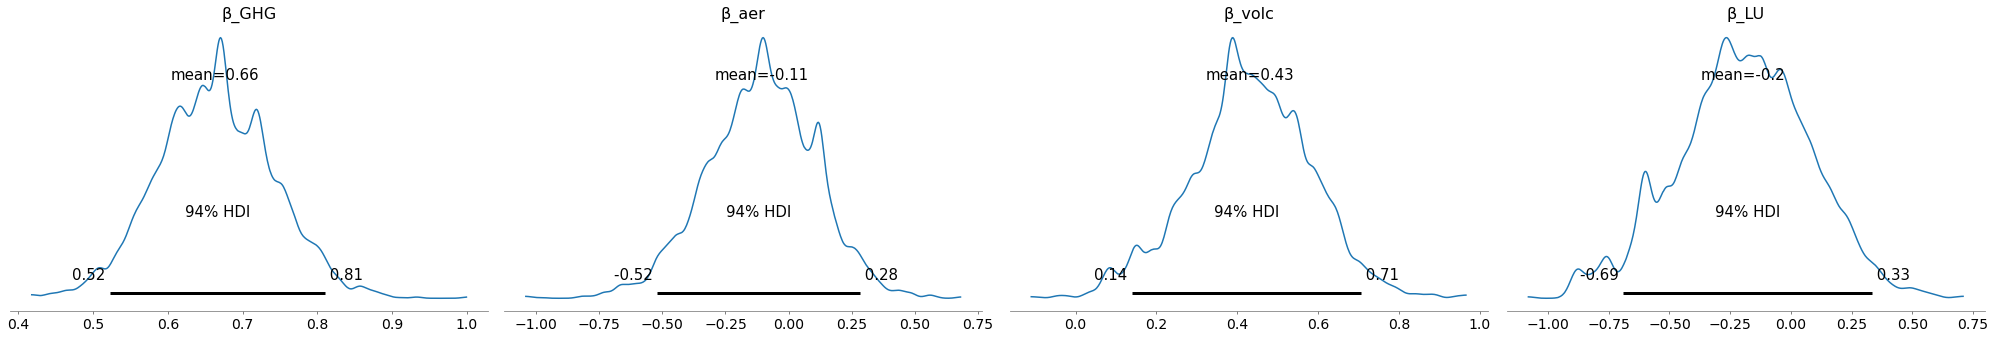

In [323]:
az.plot_posterior(trace,var_names=["β_GHG","β_aer","β_volc","β_LU"])

/Users/kmarvel/Applications/anaconda3/envs/cdat_lite/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'β_GHG'}>,
       <AxesSubplot:title={'center':'β_aer'}>,
       <AxesSubplot:title={'center':'β_volc'}>,
       <AxesSubplot:title={'center':'β_Orb'}>], dtype=object)

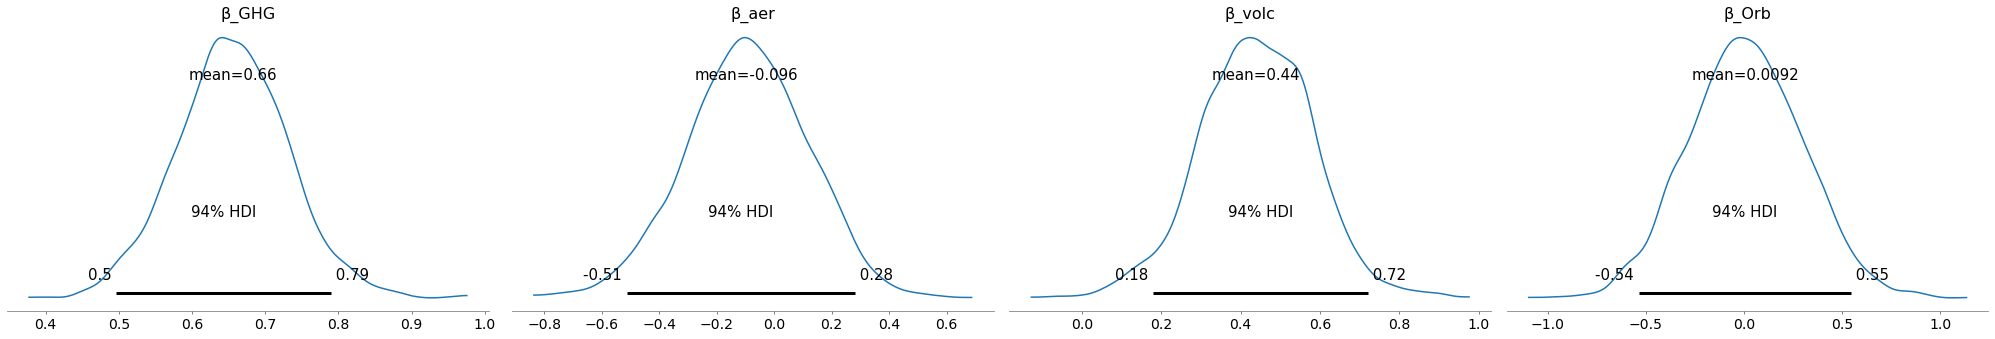

In [290]:
az.plot_posterior(trace,var_names=["β_GHG","β_aer","β_volc","β_Orb"])

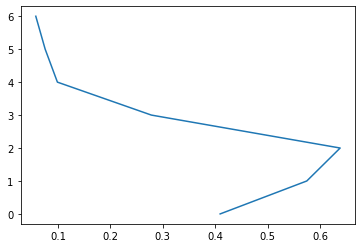

In [469]:
pic=forced_response("piControl")
pic_clim=np.average(pic[:,:,-20:],axis=-1)[:,:,np.newaxis]
pic_anom=pic-pic_clim
nens,ns,nt=pic_anom.shape
pic_flatten=np.reshape(np.transpose(pic_anom,axes=[0,2,1]),(nens*nt,ns))
Nsamp=pic_flatten.shape[0]
Chat=1/(Nsamp-1)*np.dot(pic_flatten.T,pic_flatten)
pvals,pvecs=np.linalg.eig(Chat)
plt.plot(pvecs[:,0],h)

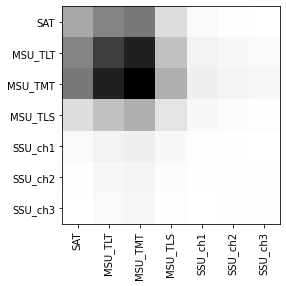

In [229]:
plt.set_cmap(cm.Greys)
tmp=plt.imshow(Chat)
tmp=plt.xticks(np.arange(7),list(OBS.keys()),rotation=90)
tmp=plt.yticks(np.arange(7),list(OBS.keys()))

In [222]:
def average_datasets(OBS):
    datasets=[]
    for V in variables:
        datasets+=list(OBS[V].keys())
    datasets=np.unique(datasets)
    nobs=len(datasets)
    nt_obs=len(OBS["SAT"]["GISTEMP"])
    ns_obs=len(variables)
    mobs=np.ma.zeros((nobs,ns_obs,nt_obs))+1.e20

    for i in range(nobs):

        dset=datasets[i]
        print(dset)
        for j in range(ns):
            vari=variables[j]
            if dset in OBS[vari].keys():
                mobs[i,j]=OBS[vari][dset]
    mobs=np.ma.masked_where(mobs>1.e10,mobs)
    avobs=np.ma.average(mobs,axis=0)
    return avobs

In [131]:
# Spatial 


(7, 15)

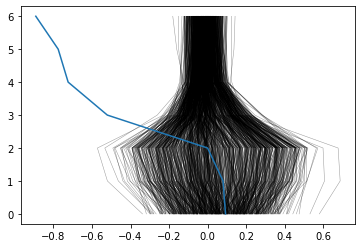

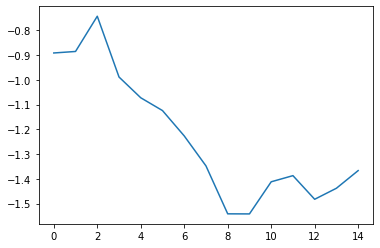

In [38]:
plt.plot(avobs[-1])

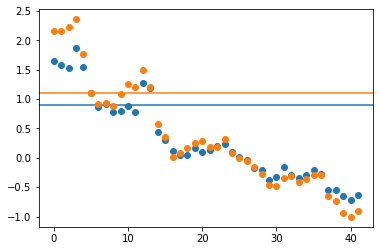

In [51]:
noaa="/Users/kmarvel/Documents/PAPERS/VerticalTemperature/OBS/NOAA_star/ssu_anom_ann.lp"
noaa_df=pd.read_csv(noaa, sep=' ',header=None,names=["Year","SSU_ch1","SSU_ch2","SSU_ch3"])
plt.plot(noaa_df["SSU_ch1"].values,"o")
plt.axhline(np.average(noaa_df["SSU_ch1"].values[:20]))
plt.plot(noaa_df["SSU_ch3"].values,"o")
plt.axhline(np.average(noaa_df["SSU_ch3"].values[:20]),c=cm.tab10(1))

In [48]:
noaa_df

,Year,SSU_ch1,SSU_ch2,SSU_ch3
0,1979,1.654854,1.922074,2.161304
1,1980,1.584096,1.881708,2.161008
2,1981,1.525913,1.856483,2.223958
3,1982,1.872571,2.025649,2.358933
4,1983,1.552263,1.623349,1.768016
5,1984,1.095663,1.255135,1.106150
6,1985,0.873530,0.924149,0.912208
7,1986,0.912937,0.940724,0.938166
8,1987,0.779046,0.762691,0.878916
9,1988,0.790246,0.846949,1.085833


In [59]:
aerlong=forced_anomalies("TA",average=False,startyear=1979,stopyear=2014,climstart=1979,climstop=1999)
aerav=np.average(aerlong,axis=0).T

<ipython-input-4-b85e7602d8bf>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv(datafile, sep='   ',skiprows=4,names=["Year","Value"])


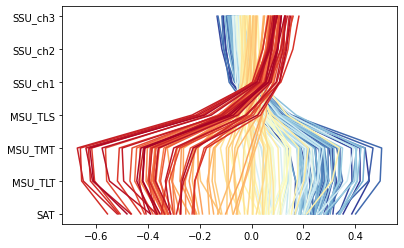

In [113]:
h=np.arange(7)
tmp=[plt.plot(aertestav_anom0.T[i],h,c=cm.RdYlBu_r(i/165.)) for i in range(165)]
labs=plt.yticks(np.arange(7),variables)
#plt.xlim(-2,2)

In [107]:
aertest=forced_response("TA")
aertest.shape

<ipython-input-4-b85e7602d8bf>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv(datafile, sep='   ',skiprows=4,names=["Year","Value"])


(5, 7, 165)

In [118]:
aertestav=np.average(aertest,axis=0)
np.average(aertestav[:20],axis=1)

array([ 13.38077079,  -3.4998228 , -22.94378958, -64.81004   ,
       -42.14587467, -26.60235006, -16.97447891])

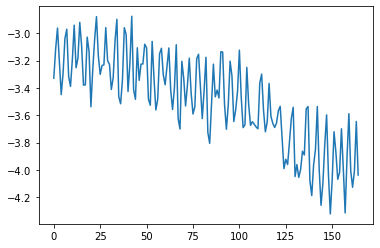

In [121]:
plt.plot(aertest[0,1])

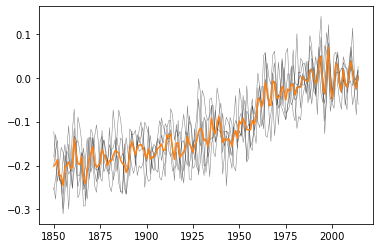

In [100]:
[plt.plot(tyear,aertest[i,-1]-clim[-1],c="k",lw=.5,alpha=0.5) for i in range(5)]
plt.plot(tyear[129:],aerav[:,-1])
plt.plot(tyear,aertestav[-1]-clim[-1])

In [ ]:
[plt.plot(tyear,aertest[i,-1]-clim[-1],c="k",lw=.5,alpha=0.5) for i in range(5)]
plt.plot(tyear[129:],aerav[:,-1])
plt.plot(tyear,aertestav[-1]-clim[-1])

In [82]:
tyear=np.arange(1850,2015,1)

In [83]:
np.where(tyear==1979)

(array([129]),)

In [86]:
clim=np.average(aertestav[:,129:149],axis=1)
clim.shape

(7,)

In [90]:
aerav.shape

(36, 7)